## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
train_img_dir = "hirise-3.2/HiRISE-train"
val_img_dir = "hirise-3.2/HiRISE-val"
test_img_dir = "hirise-3.2/HiRISE-test"

2023-10-18 13:39:31.907964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:39:32.435655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-10-18 13:39:33.076876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 13:39:33.084878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 13:39:33.085215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Input pipeline
Using the Keras ImageDataGenerator, the dataset is split into train and validation in an 80/20 split. Class weights are calulated after loading the dataset.

In [3]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Set the image size and batch size
img_height = 227
img_width = 227
batch_size = 2

# Create ImageDataGenerator for data augmentation and loading the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # Normalize pixel values to [0, 1]
    validation_split=0.2 # set validation split
    # Add other data augmentation parameters as needed
)

# Load the dataset using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_img_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    val_img_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='validation')

test_generator = train_datagen.flow_from_directory(
    test_img_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='validation')

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)


# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("")
print(class_weights_dict)
'''
#show some images
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))

for i in range(5):
    for j in range(10):

        # convert to unsigned integers for plotting
        image = next(train_generator)[0][0]

        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
        image = np.squeeze(image)

        # plot raw pixel data
        ax[i][j].imshow(image)
        ax[i][j].axis('off')
'''

Found 7171 images belonging to 7 classes.
Found 588 images belonging to 7 classes.
Found 59 images belonging to 7 classes.

{0: 0.820199016355942, 1: 0.35582791643923983, 2: 2.0779484207476093, 3: 3.725194805194805, 4: 1.3843629343629344, 5: 2.0086834733893557, 6: 0.9994425087108014}


"\n#show some images\nfig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))\n\nfor i in range(5):\n    for j in range(10):\n\n        # convert to unsigned integers for plotting\n        image = next(train_generator)[0][0]\n\n        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image\n        image = np.squeeze(image)\n\n        # plot raw pixel data\n        ax[i][j].imshow(image)\n        ax[i][j].axis('off')\n"

## Here, the dataset's class distribution is shown to verify the split

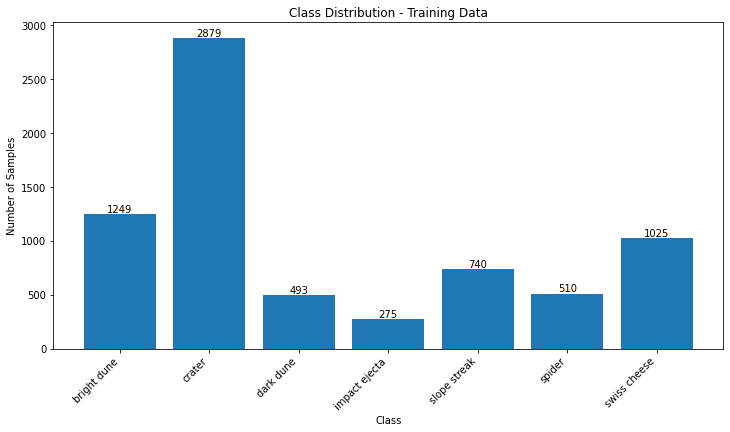

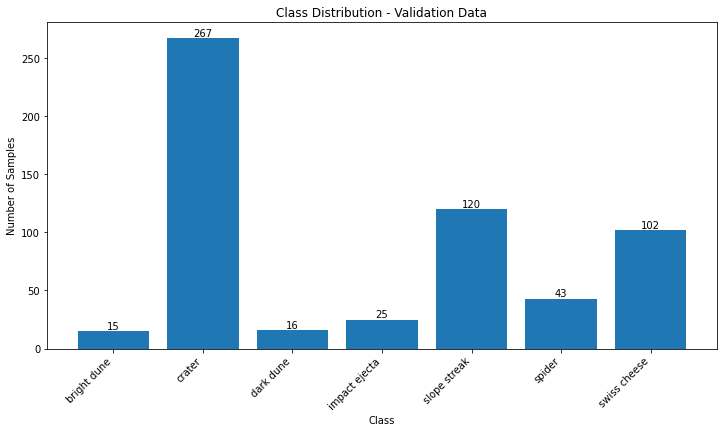

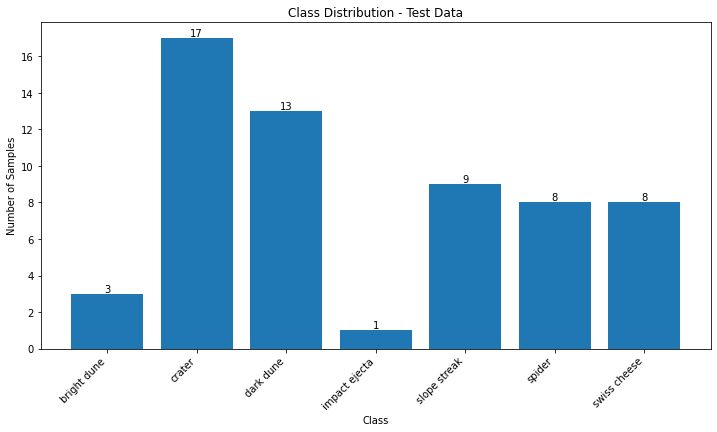

In [4]:
import matplotlib.pyplot as plt

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Count the number of samples for each class in the training data
train_class_counts = np.zeros(num_classes)
for _, labels in train_generator:
    for label in labels.argmax(axis=1):
        train_class_counts[label] += 1
    if train_generator.batch_index == 0:
        break

# Count the number of samples for each class in the validation data
validation_class_counts = np.zeros(num_classes)
for _, labels in validation_generator:
    for label in labels.argmax(axis=1):
        validation_class_counts[label] += 1
    if validation_generator.batch_index == 0:
        break

# Count the number of samples for each class in the validation data
test_class_counts = np.zeros(num_classes)
for _, labels in test_generator:
    for label in labels.argmax(axis=1):
        test_class_counts[label] += 1
    if test_generator.batch_index == 0:
        break
        

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the class distribution for training data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, train_class_counts)
plt.title("Class Distribution - Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(train_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the class distribution for validation data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, validation_class_counts)
plt.title("Class Distribution - Validation Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(validation_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the class distribution for test data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, test_class_counts)
plt.title("Class Distribution - Test Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(test_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

## Part 2/3: Building and Training

In [5]:
''' older alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

#old alexnet

'''

' older alexnet\nmodel = keras.models.Sequential([\n    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=\'relu\', input_shape=(img_height, img_width,3)),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=

In [6]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

# 5 convolutional layers
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7))
model.add(Activation('softmax'))

2023-10-18 13:39:36.968098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 13:39:36.968472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 13:39:36.968754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                   

In [9]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [10]:
#train the model, time to cook!


#set up tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs=10

history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [tensorboard_callback],
    class_weight = class_weights_dict
)

Epoch 1/10


2023-10-18 13:39:38.987743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-18 13:39:39.266306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-18 13:39:39.268450: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f88c95a20d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-18 13:39:39.268466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-10-18 13:39:39.271972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-18 13:39:39.367321: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

3585/3585 [==============================] - ETA: 0s - loss: 1.5376 - accuracy: 0.4227

2023-10-18 13:40:20.640961: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 713687040 exceeds 10% of free system memory.
2023-10-18 13:40:20.898310: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212336640 exceeds 10% of free system memory.
2023-10-18 13:40:20.985689: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318504960 exceeds 10% of free system memory.
2023-10-18 13:40:21.097202: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212336640 exceeds 10% of free system memory.
2023-10-18 13:40:21.183789: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251658240 exceeds 10% of free system memory.


3585/3585 [==============================] - 46s 12ms/step - loss: 1.5376 - accuracy: 0.4227 - val_loss: 1.5076 - val_accuracy: 0.4388
Epoch 2/10
3585/3585 [==============================] - 42s 12ms/step - loss: 1.1652 - accuracy: 0.5707 - val_loss: 1.6364 - val_accuracy: 0.4473
Epoch 3/10
3585/3585 [==============================] - 44s 12ms/step - loss: 0.9787 - accuracy: 0.6430 - val_loss: 1.3939 - val_accuracy: 0.4762
Epoch 4/10
3585/3585 [==============================] - 45s 12ms/step - loss: 0.8724 - accuracy: 0.6828 - val_loss: 1.2220 - val_accuracy: 0.5731
Epoch 5/10
3585/3585 [==============================] - 45s 12ms/step - loss: 0.7997 - accuracy: 0.7079 - val_loss: 1.1780 - val_accuracy: 0.5748
Epoch 6/10
3585/3585 [==============================] - 49s 14ms/step - loss: 0.7264 - accuracy: 0.7383 - val_loss: 1.1450 - val_accuracy: 0.6054
Epoch 7/10
3585/3585 [==============================] - 49s 14ms/step - loss: 0.6640 - accuracy: 0.7665 - val_loss: 0.9715 - val_accura

# 

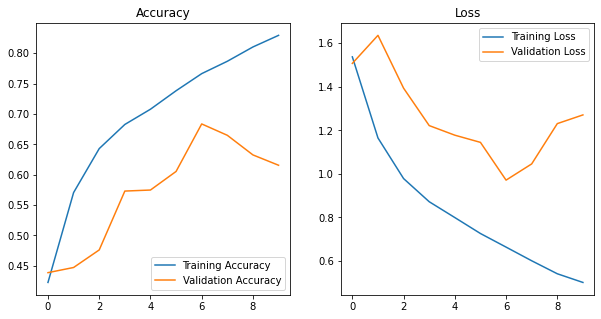

In [11]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [12]:
# evaluate the accuracy
score = model.evaluate(validation_generator, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

Validation Loss: 1.271041989326477
Validation Accuracy: 0.615646243095398
Min Validation Loss: 0.971544623374939
Max Validation Accuracy: 0.6836734414100647


In [15]:
# generate the confusion matrix

# predict on the test dataset
test_predictions = model.predict(test_generator)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_generator.classes, predicted_labels)

30/30 [==============================] - 0s 3ms/step


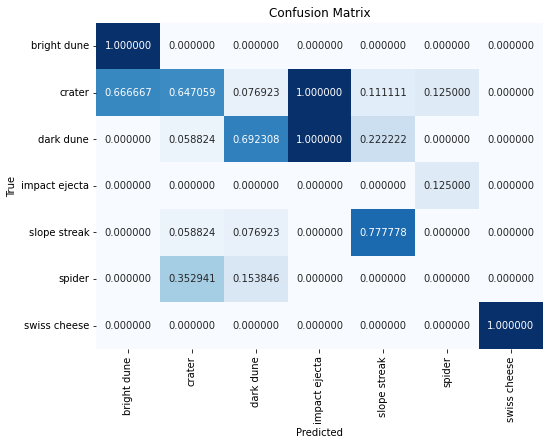

In [18]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion / confusion.astype(float).sum(axis=1), annot=True, fmt="f", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(test_generator.classes, predicted_labels, average=None)
recall_per_class = recall_score(test_generator.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(test_generator.classes, predicted_labels, average='weighted')
overall_recall = recall_score(test_generator.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(test_generator.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

Class: bright dune
Precision: 0.60
Recall: 1.00
------------
Class: crater
Precision: 0.58
Recall: 0.65
------------
Class: dark dune
Precision: 0.69
Recall: 0.69
------------
Class: impact ejecta
Precision: 0.00
Recall: 0.00
------------
Class: slope streak
Precision: 0.70
Recall: 0.78
------------
Class: spider
Precision: 0.00
Recall: 0.00
------------
Class: swiss cheese
Precision: 1.00
Recall: 1.00
------------
Overall Precision: 0.5922390722569135
Overall Recall: 0.6440677966101694
Classification Report:
                precision    recall  f1-score   support

  bright dune       0.60      1.00      0.75         3
       crater       0.58      0.65      0.61        17
    dark dune       0.69      0.69      0.69        13
impact ejecta       0.00      0.00      0.00         1
 slope streak       0.70      0.78      0.74         9
       spider       0.00      0.00      0.00         8
 swiss cheese       1.00      1.00      1.00         8

     accuracy                           0.